# 01 Import Libraries

In [1]:
import os
import re
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# 02 Slice Image Acquisition & Visualization

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))
    
    return (slices, ID)

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
slices

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


['sample-dataset/ID00007637202177411956430_0.jpg',
 'sample-dataset/ID00007637202177411956430_1.jpg',
 'sample-dataset/ID00007637202177411956430_2.jpg',
 'sample-dataset/ID00007637202177411956430_3.jpg',
 'sample-dataset/ID00007637202177411956430_4.jpg',
 'sample-dataset/ID00007637202177411956430_5.jpg',
 'sample-dataset/ID00007637202177411956430_6.jpg',
 'sample-dataset/ID00007637202177411956430_7.jpg',
 'sample-dataset/ID00007637202177411956430_8.jpg',
 'sample-dataset/ID00007637202177411956430_9.jpg',
 'sample-dataset/ID00007637202177411956430_10.jpg',
 'sample-dataset/ID00007637202177411956430_11.jpg',
 'sample-dataset/ID00007637202177411956430_12.jpg',
 'sample-dataset/ID00007637202177411956430_13.jpg',
 'sample-dataset/ID00007637202177411956430_14.jpg',
 'sample-dataset/ID00007637202177411956430_15.jpg',
 'sample-dataset/ID00007637202177411956430_16.jpg',
 'sample-dataset/ID00007637202177411956430_17.jpg',
 'sample-dataset/ID00007637202177411956430_18.jpg',
 'sample-dataset/ID000

In [4]:
def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [5]:
sliceImgs = getSliceImages(slices)

In [6]:
def showImages(slices, cols, ID):
    sliceCount = len(slices)
    rows = int(sliceCount / cols)

    fig, ax = plt.subplots(nrows = rows if sliceCount % cols == 0 else rows + 1 , 
                           ncols = cols, 
                           figsize = (20, 50))
    counter = 0
    for i in range(rows):
        for j in range(cols):
            
            ax[i, j].imshow(slices[counter], cmap ='gray')
            ax[i,j].set_title('Slice %d' % (counter + 1))
            ax[i,j].axis('off')
            counter += 1

    if (sliceCount / cols) != rows:
        for j in range(sliceCount % cols):
            ax[rows,j].imshow(slices[counter], cmap ='gray')
            ax[rows,j].set_title('Slice %d' % (counter + 1))
            ax[rows,j].axis('off')
            counter += 1
            
    plt.show()

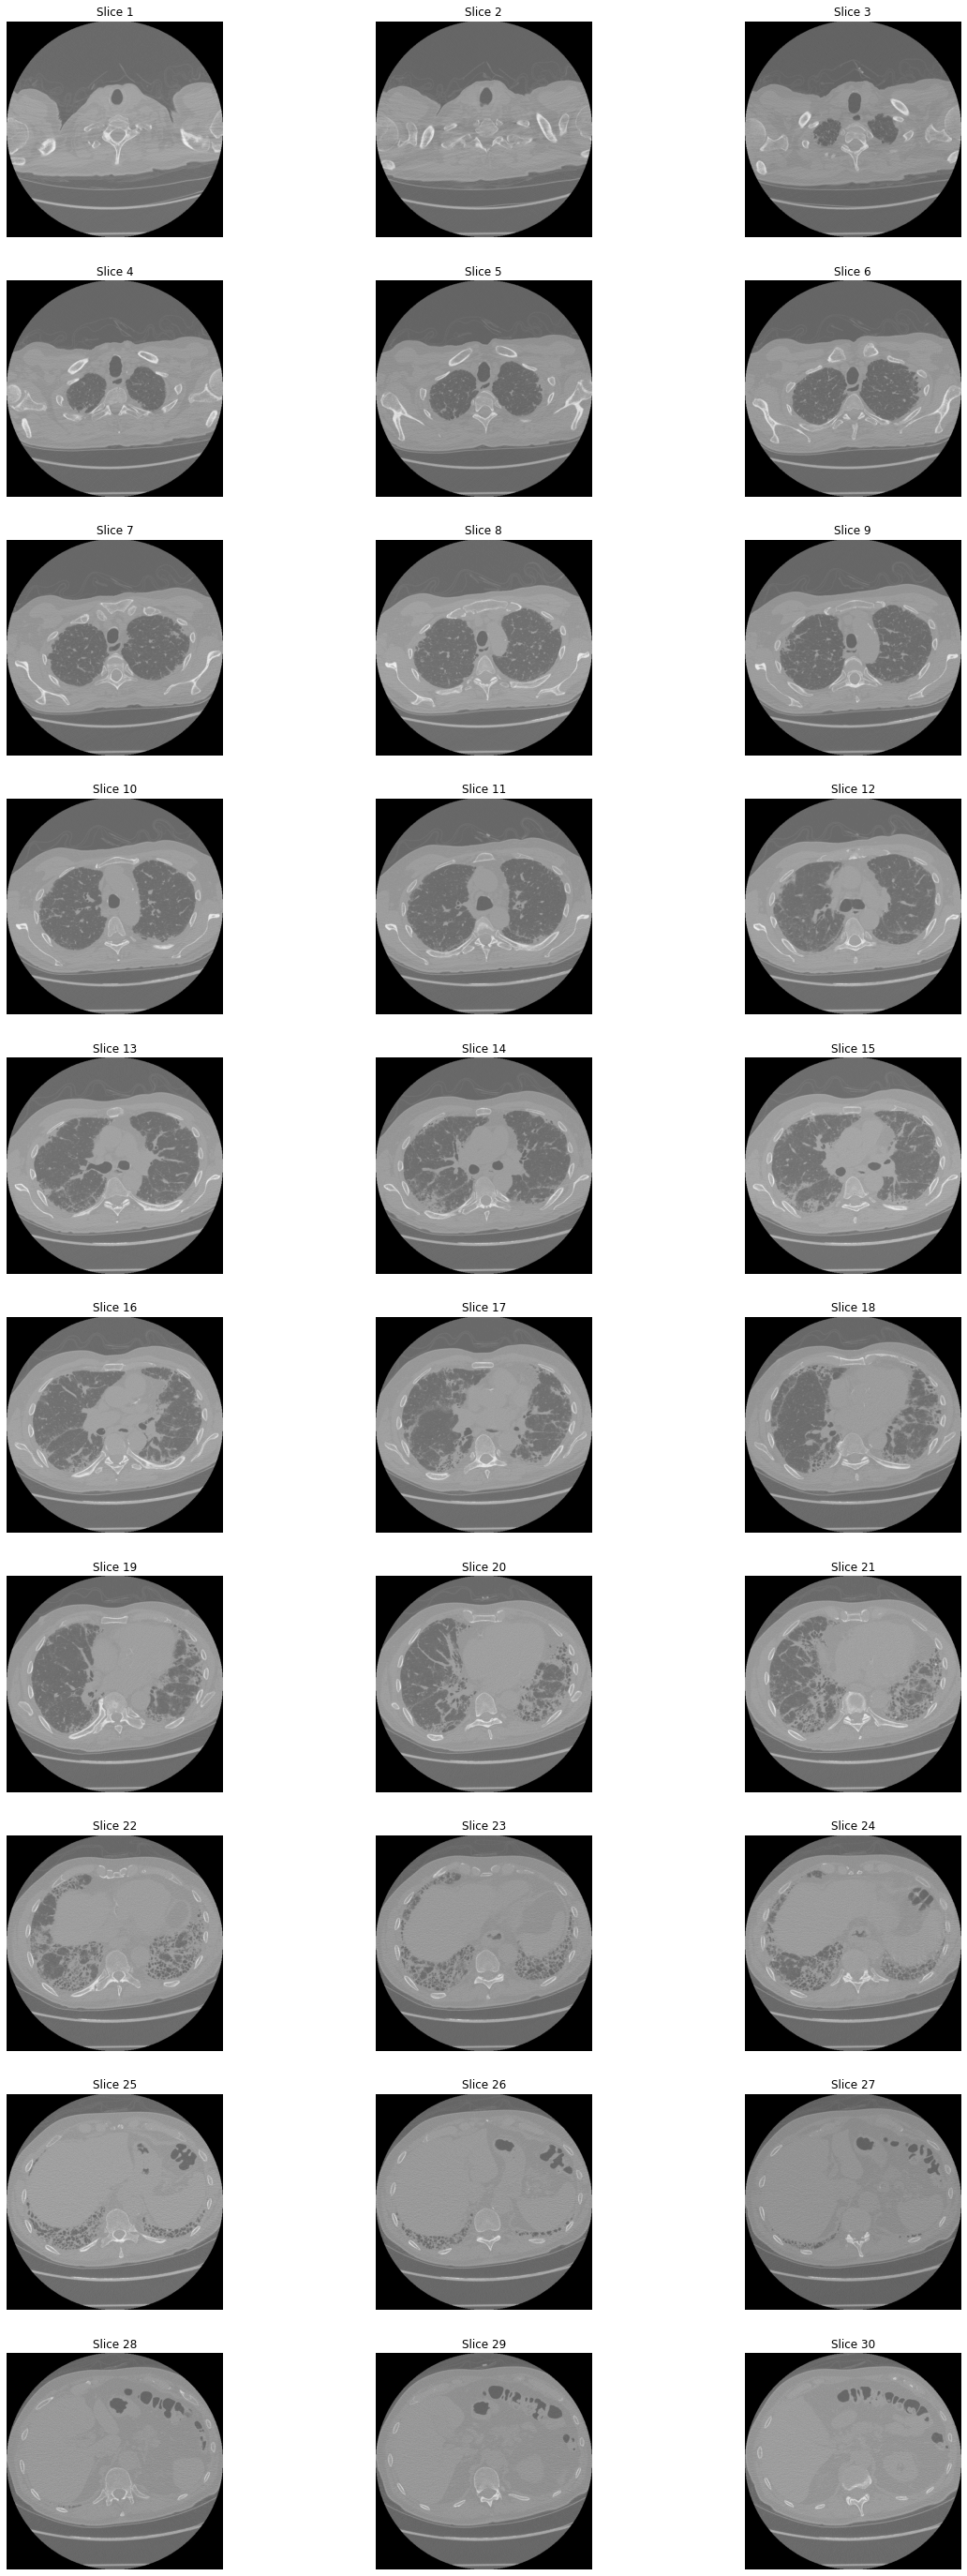

In [7]:
showImages(sliceImgs, 3, PatientID)

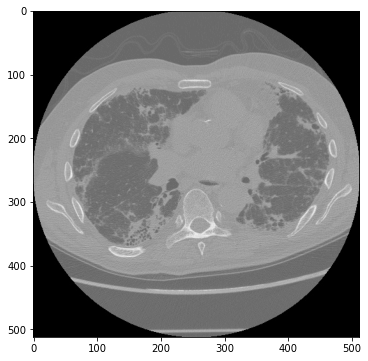

In [8]:
plt.figure(figsize = (12, 6))
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.imshow(im, cmap='gray')

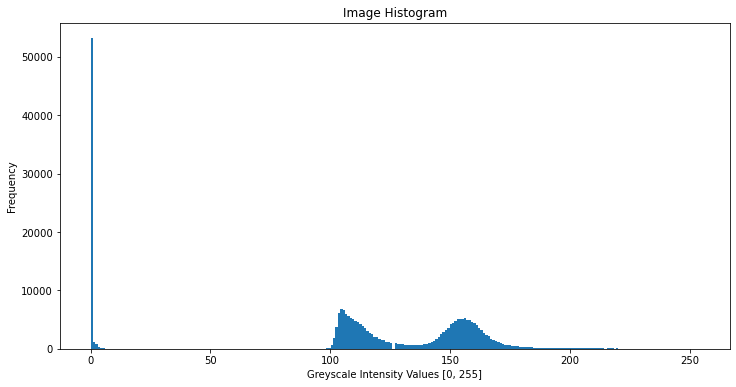

In [9]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [10]:
im[im < 0]

array([], dtype=uint8)

In [11]:
im[im > 255]

array([], dtype=uint8)

# 03 Slice Image Preprocessing
## 3.1 Calculate Statistically Derived Thresholds 
Obtain the statistically derived thresholds needed in order to define the binary masks. These thresholds depend on the distribution of the image histogram.
### 3.1.1 Mean Value of Intensity of Pixels, $\mu(k)$

In [12]:
# Calculate the average intensity of the kth slice
mu_k = im.mean()
mu_k

107.61984634399414

Text(0.5, 1.0, 'Binary Image after Thresholding with the Mean')

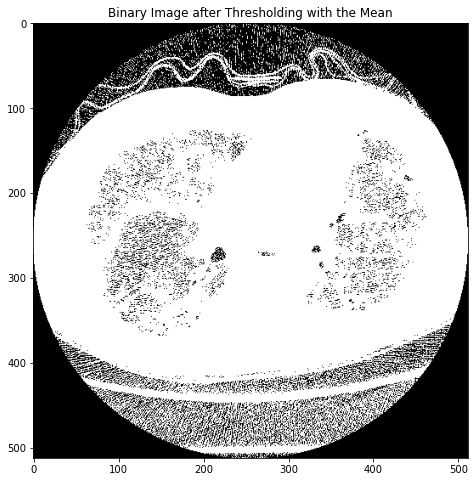

In [13]:
# Create a binary mask by thresholding with the average
bmask = cv2.threshold(im, mu_k, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 8))
plt.imshow(bmask[1], cmap='gray')
plt.title('Binary Image after Thresholding with the Mean')

### 3.1.2 Mean Value of Pixels with Intensity $> \mu(k), \mu_{sup} (k)$
The output binary mask determines the position of the spine in a slice.

In [14]:
pixelsGreaterThanMean = np.where(im.flatten() > mu_k)[0]
R_k = len(pixelsGreaterThanMean)
R_k

174524

In [15]:
levelsGreaterThanMean = im.flatten()[pixelsGreaterThanMean]

In [16]:
mu_sup_k = levelsGreaterThanMean.mean()
mu_sup_k

142.48654626297815

Text(0.5, 1.0, 'Binary Image after Thresholding with the Upper Mean')

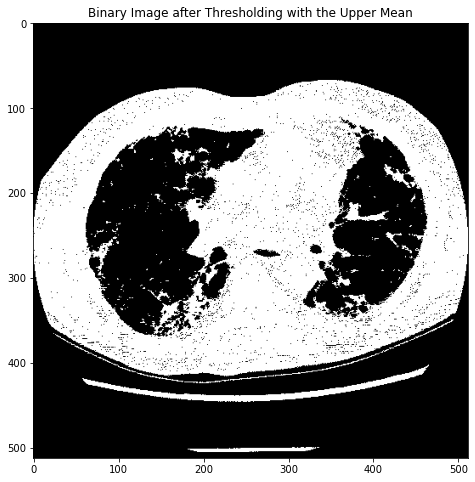

In [17]:
# Create a binary mask by thresholding with the average
bmask = cv2.threshold(im, mu_sup_k, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 8))
plt.imshow(bmask[1], cmap='gray')
plt.title('Binary Image after Thresholding with the Upper Mean')

### 3.1.3 Standard Deviation of Intensities of Pixels with Intensity $>\mu(k), \sigma_{sup}(k)$

In [18]:
# Calculate standard deviation
sigma_k = im.flatten()[pixelsGreaterThanMean].std()
sigma_k

22.968593239803816

### 3.1.4 Threshold to locate rib bones & structures with oxygenated blood flow: $\mu(k) - \sigma_{sup}(k)$ 

In [19]:
muSupSDBinMask = im > mu_sup_k + sigma_k

Text(0.5, 1.0, 'Binary Image after Thresholding with the Upper Mean + Std Dev of Upper Distribution')

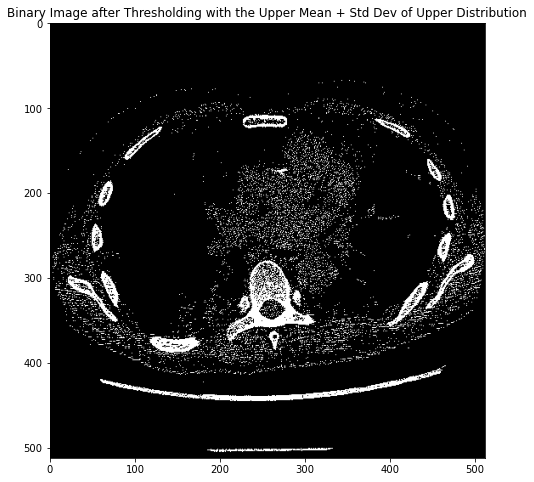

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(muSupSDBinMask, cmap='gray')
plt.title('Binary Image after Thresholding with the Upper Mean + Std Dev of Upper Distribution')

#### Histogram with the Calculated Statistical Parameters

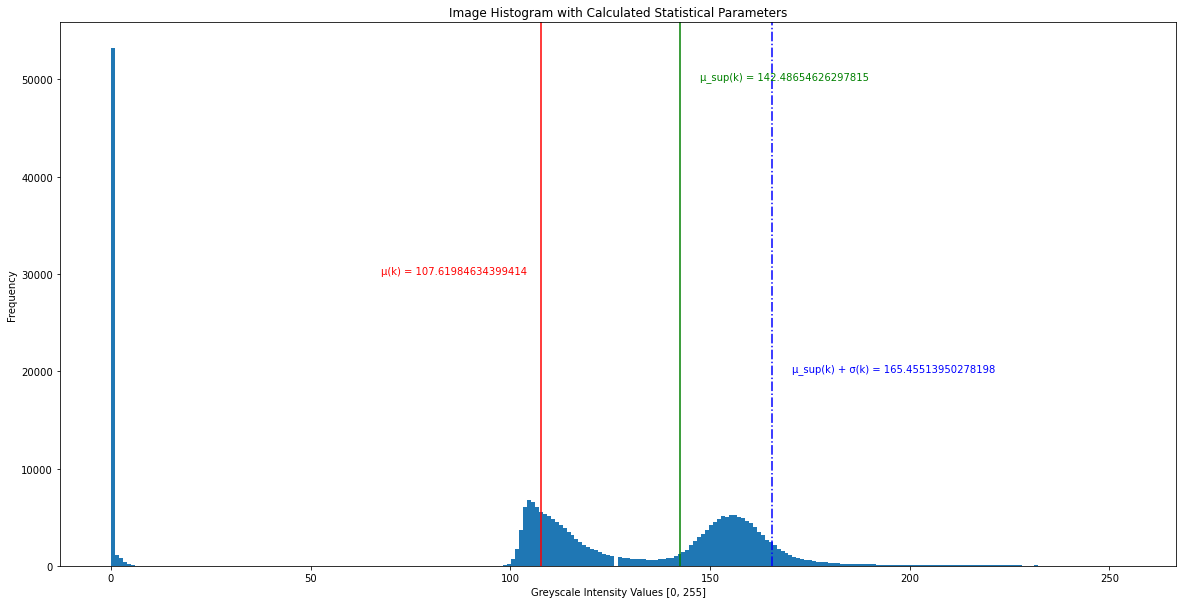

In [21]:
plt.figure(figsize = (20, 10))

# Mean line
plt.axvline(x = mu_k, c = 'red')
plt.text(x = mu_k - 40, 
         y = 30000, 
         s = "μ(k) = " + str(mu_k), 
         c = 'red')

# Upper mean line
plt.axvline(x = mu_sup_k, c = 'green')
plt.text(x = mu_sup_k + 5, 
         y = 50000, 
         s = "μ_sup(k) = " + str(mu_sup_k), 
         c = 'green')


# Upper mean + Std Dev line
plt.axvline(x = mu_sup_k + sigma_k, c = 'blue', linestyle = '-.' )
plt.text(x = mu_sup_k + sigma_k + 5, 
         y = 20000, 
         s = "μ_sup(k) + σ(k) = " + str(mu_sup_k + sigma_k), 
         c = 'blue')

plt.title('Image Histogram with Calculated Statistical Parameters')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

### 3.1.5 Global Mean, $\mu_{global}(k) = Mean(\mu_{sup}(k)) - StdDev(\mu_{sup}(k))$ 
Thresholding with $\mu_{global}$ shows parts of the images constituting muscular tissues.
To calculate the global mean, we iterate through each slice of a patient.

In [22]:
mu_sups = []

# For each slice, calculate upper mean and append to the list
for i in range(len(sliceImgs)):
    ctSlice = sliceImgs[i].flatten()
    
    # Calculate mean of Slice i
    mu_i = ctSlice.mean()
    
    # Calculate the upper mean of Slice i
    greaterThanMu = np.where(ctSlice > mu_i)[0]
    mu_sup_i = ctSlice[greaterThanMu].mean()
    
    mu_sups.append(mu_sup_i)
mu_sups

[134.6926657070047,
 137.50643097381612,
 136.1070893219293,
 142.60137836425397,
 137.3881995585211,
 137.48493477694504,
 136.90542849143816,
 140.14644997173545,
 134.4070287118426,
 136.20002620645224,
 135.21424045793188,
 139.360122716497,
 140.85164051355207,
 137.74408105882813,
 145.6434959933366,
 142.14780021301894,
 142.48654626297815,
 142.1761921969529,
 145.02425018954645,
 145.20440176023533,
 149.37899645161485,
 149.3178069279711,
 146.47216077364763,
 148.1368055639116,
 154.73379531046567,
 148.36526526406595,
 141.96954647000888,
 147.71164698005833,
 146.42985657555533,
 151.2159078691149]

Text(0.5, 1.0, 'Binary Image after Thresholding with the Global Mean')

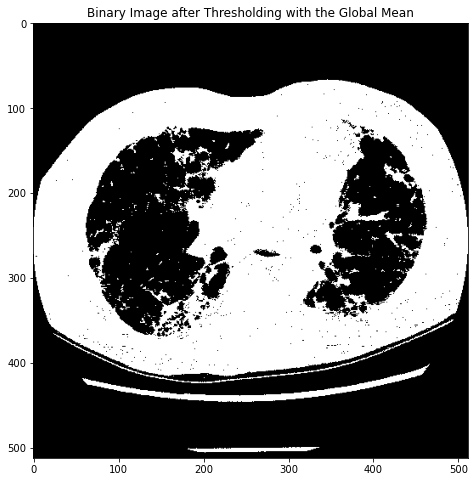

In [23]:
# Calculate the global mean
mu_global = np.mean(mu_sups) - np.std(mu_sups)

# Perform thresholding on one slice with the global mean
mu_global_bMask = im > mu_global

# Show the binary image after thresholding
plt.figure(figsize=(10, 8))
plt.imshow(mu_global_bMask, cmap='gray')
plt.title('Binary Image after Thresholding with the Global Mean')